<a href="https://colab.research.google.com/github/ADRIAN02-CODE/telco-churn-prediction/blob/main/telco_churn_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:


import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve
)
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import joblib

# Keras imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Optional SMOTE
try:
    from imblearn.over_sampling import SMOTE
    IMBLEARN_AVAILABLE = True
except Exception:
    IMBLEARN_AVAILABLE = False

RANDOM_STATE = 42
TEST_SIZE = 0.2
np.random.seed(RANDOM_STATE)

print('✅ Libraries imported.')


✅ Libraries imported.


In [4]:

EXCEL_PATHS = [
    'Telecom Dataset.xlsx',
    'Telecom Dataset .xlsx',
    '/content/Telecom Dataset.xlsx',
    '/content/Telecom Dataset .xlsx',
    'telco_customer_churn.xlsx',
    'WA_Fn-UseC_-Telco-Customer-Churn.csv'
]

data_loaded = False
for path in EXCEL_PATHS:
    if os.path.exists(path):
        if path.lower().endswith('.csv'):
            df = pd.read_csv(path)
        else:
            df = pd.read_excel(path, engine='openpyxl')
        print(f'✅ Loaded data from: {path} | shape: {df.shape}')
        data_loaded = True
        break

if not data_loaded:
    raise FileNotFoundError('❌ Dataset not found. Please upload the Telco dataset and set EXCEL_PATH correctly.')

print(df.columns.tolist())
df.head()


✅ Loaded data from: WA_Fn-UseC_-Telco-Customer-Churn.csv | shape: (7043, 21)
['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  704

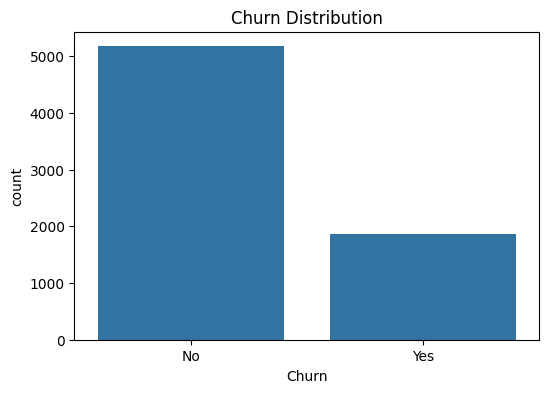

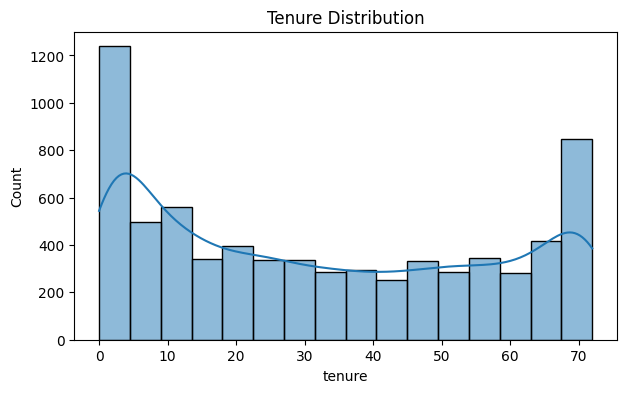

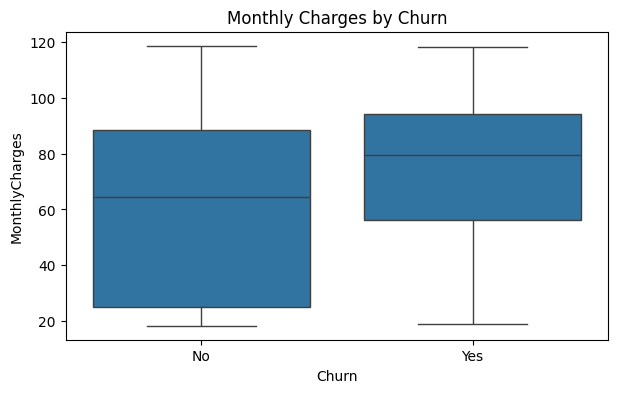

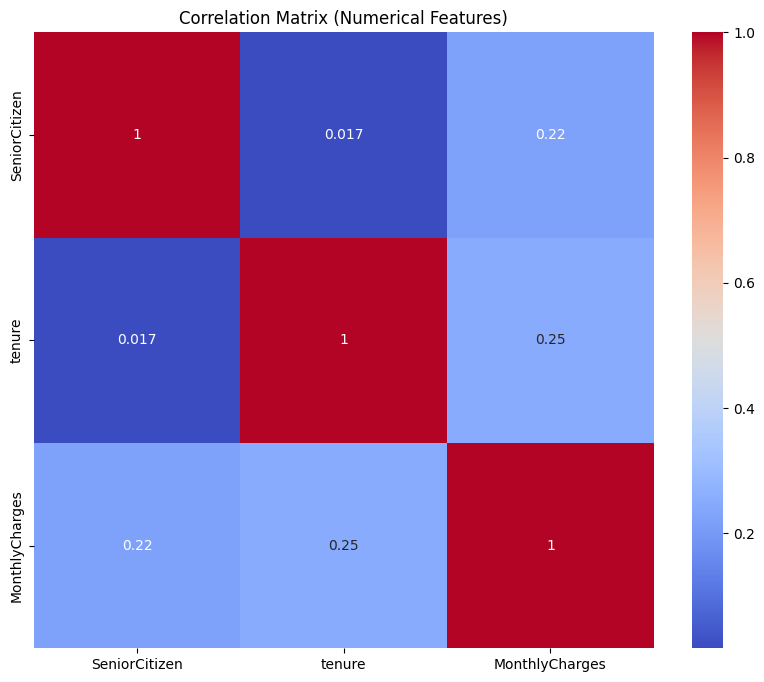

Missing values:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [5]:
print("--- Dataset Info ---")
print(df.info())

# Remove spaces in text fields
for col in df.select_dtypes(include=["object"]).columns:
    df[col] = df[col].astype(str).str.strip()

# Class distribution
plt.figure(figsize=(6,4))
sns.countplot(x="Churn", data=df)
plt.title("Churn Distribution")
plt.show()

# Tenure distribution
plt.figure(figsize=(7,4))
sns.histplot(df["tenure"].astype(float), kde=True)
plt.title("Tenure Distribution")
plt.show()

# Monthly Charges vs Churn
plt.figure(figsize=(7,4))
sns.boxplot(x="Churn", y="MonthlyCharges", data=df)
plt.title("Monthly Charges by Churn")
plt.show()

# Correlation Heatmap
num_cols = df.select_dtypes(include=np.number)
plt.figure(figsize=(10,8))
sns.heatmap(num_cols.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix (Numerical Features)")
plt.show()

print("Missing values:")
print(df.isnull().sum())


!git config --global user.name "Adrian02-CODE"
!git config --global user.email "adrianvethanayagam@gmail.com"
